# Running GNN on real-world tracked data

In [1]:
%load_ext autoreload
%autoreload 2

from collab_env.data.file_utils import expand_path, get_project_root
from collab_env.gnn.gnn import train_rules_gnn
from collab_env.gnn.utility import dataset2testloader
from collab_env.sim.boids_gnn_temp.animal_simulation_from_data_old import visualize_graph_2sets, static_visualize_2sets
from collab_env.gnn.gnn import debug_result2prediction
import matplotlib.pyplot as plt
from rich import print
import seaborn as sns
import pandas as pd
import torch
import numpy as np
from tqdm.notebook import tqdm
from typing import List, Tuple
from pathlib import Path
from loguru import logger
import pickle
%matplotlib inline

do_pretrain = True # if True, load pre-trained GNN
do_train = True # if True, train GNN on real tracks 
# if both are False, will run an un-trained GNN
train_size = 0.4


device = torch.device("cpu")

## Current format consumed by the GNN

In [2]:
boid_dummy_data_fn = expand_path(
    "simulated_data/boid_single_species_basic.pt",
    get_project_root(),
)

boid_dummy_ds = torch.load(boid_dummy_data_fn, weights_only = False)
print(type(boid_dummy_ds))
print(f"Length of boid_dummy_ds: {len(boid_dummy_ds)}")
for i in range(3):
    p, sp = boid_dummy_ds[i]    
    print(f"i={i}, p.shape: {p.shape}, sp.shape: {sp.shape}")

<class 'collab_env.sim.boids_gnn_temp.animal_simulation.AnimalTrajectoryDataset'>

Length of boid_dummy_ds: 1000

i=0, p.shape: torch.Size([800, 20, 2]), sp.shape: torch.Size([20])

i=1, p.shape: torch.Size([800, 20, 2]), sp.shape: torch.Size([20])

i=2, p.shape: torch.Size([800, 20, 2]), sp.shape: torch.Size([20])

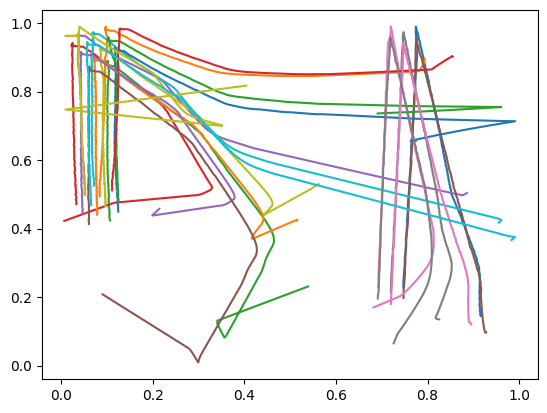

In [3]:
plt.figure()
plt.plot(p[..., 0], p[..., 1])
plt.show()

## The Data

In [4]:
real_data_fn = expand_path(
    "data/fieldwork_processed/2023_11_26-session_0001/aligned_frames/rgb_1/rgb_1_tracks.csv",
    get_project_root(),
)

real_data = pd.read_csv(real_data_fn)

print(real_data.head())

track_id  frame    x    y
0       1.0      0  448  232
1       1.0      1  437  236
2       1.0      2  434  242
3       1.0      3  430  250
4       1.0      4  430  260

In [5]:
# normalize x,y to [0,1] x [0,1]
real_data = real_data.assign(
    x_norm = lambda x: (x.x - x.x.min()) / (x.x.max() - x.x.min()),
    y_norm = lambda x: (x.y - x.y.min()) / (x.y.max() - x.y.min()),
)

In [6]:
max_seq_len = real_data.track_id.value_counts().max()
max_frame_id = real_data.frame.max() + 1
track_ids = real_data.track_id.unique()

print(f"max_seq_len: {max_seq_len}, max_frame_id: {max_frame_id}, track_ids: {len(track_ids)}")

all_tracks = torch.nan * torch.zeros(len(track_ids), max_frame_id, 2, dtype=torch.float64)
all_tracks_mask = torch.zeros(len(track_ids), max_frame_id, dtype=torch.bool)

for i, track_id in enumerate(track_ids):
    track = real_data[real_data.track_id == track_id]
    all_tracks[i, track.frame.astype(int).values, :] = torch.tensor(track[['x_norm', 'y_norm']].values)
    all_tracks_mask[i, track.frame.values] = True
    
print(f"all_tracks.shape: {all_tracks.shape}")
print(f"all_tracks_mask.shape: {all_tracks_mask.shape}")

max_seq_len: 2233, max_frame_id: 9762, track_ids: 210

all_tracks.shape: torch.Size([210, 9762, 2])

all_tracks_mask.shape: torch.Size([210, 9762])

In [7]:
def plot_tracks(tracks, mask, title="Tracks"):
    fix, ax = plt.subplots(1, 2, figsize=(6, 3))
    ax[0].spy(mask, aspect='auto')
    ax[0].set_xlabel("Frame")
    ax[0].set_ylabel("Track ID")
    ax[0].set_title("Tracks mask")
    ax[1].plot(tracks[...,0].permute(1,0), tracks[...,1].permute(1,0))
    ax[1].set_title("Real Tracks")
    plt.suptitle(f"{title}")
    plt.tight_layout()
    plt.show()

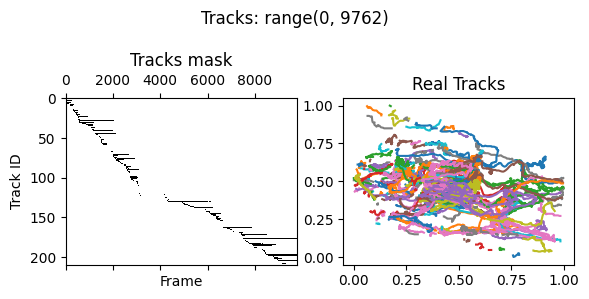

In [8]:
frame_rng = range(max_frame_id)
plot_tracks(all_tracks[...,frame_rng, :],
            all_tracks_mask[...,frame_rng],
            title=f"Tracks: {frame_rng}"
)

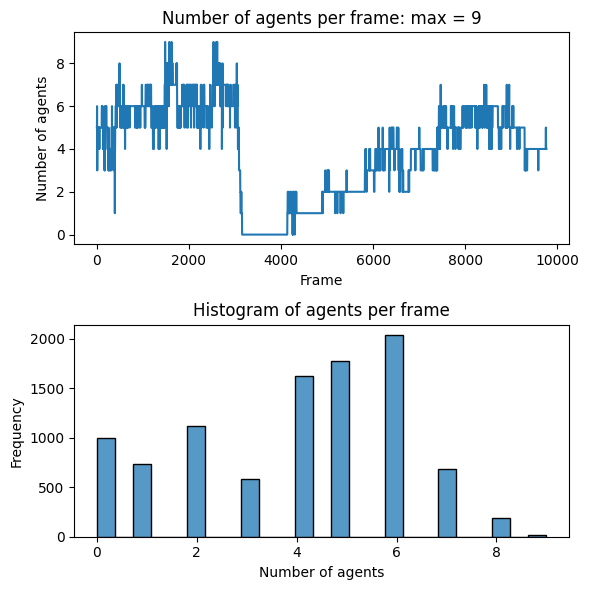

In [9]:
# max. number of agents in a frame
max_agents_per_frame = all_tracks_mask.sum(dim=0).max()
agents_per_frame = all_tracks_mask.sum(dim=0)
fig, ax = plt.subplots(2,1, figsize=(6, 6))
ax[0].plot(agents_per_frame)
ax[0].set_xlabel("Frame")
ax[0].set_ylabel("Number of agents")
ax[0].set_title(f"Number of agents per frame: max = {max_agents_per_frame}")

sns.histplot(agents_per_frame, ax=ax[1])
ax[1].set_xlabel("Number of agents")
ax[1].set_ylabel("Frequency")
ax[1].set_title(f"Histogram of agents per frame")

plt.tight_layout()
plt.show()
# split into shorter tracks and stack into a dataset

### Attempt 1 - sliding windows of large size (similar to "files")

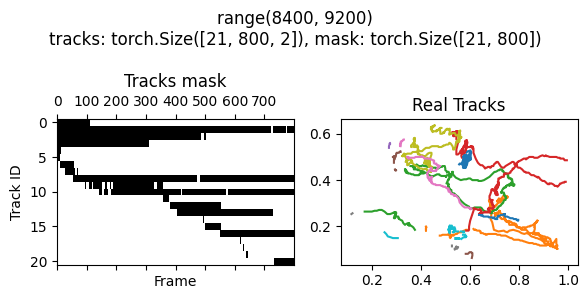

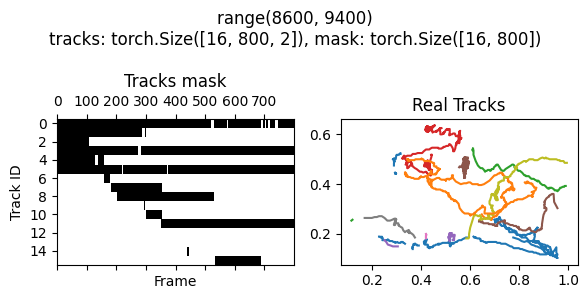

In [10]:
frame_window = 800
window_step = 200

for i in range(0, max_frame_id-frame_window, window_step)[-3:-1]:
    frame_rng = range(i, i + frame_window)
    mask = torch.zeros_like(all_tracks_mask)
    mask[:,frame_rng]  = 1
    mask_window = mask & all_tracks_mask
    row_indices = torch.nonzero(mask_window.sum(dim=1).squeeze())
    col_indices = torch.nonzero(mask_window.sum(dim=0)).squeeze()
    tracks_window = all_tracks[row_indices,col_indices,:]
    mask_window_final = mask_window[row_indices,col_indices]
    
    plot_tracks(tracks_window, mask_window_final,
                title=f"{frame_rng}\ntracks: {tracks_window.shape}, mask: {mask_window_final.shape}")


### Attempt 2 - constant #agents chunks

n_agents: 2, #chunks: 13, unique chunk_lengths: tensor([ 12,  16,  18,  42,  45,  49,  55,  70, 115, 132, 395])

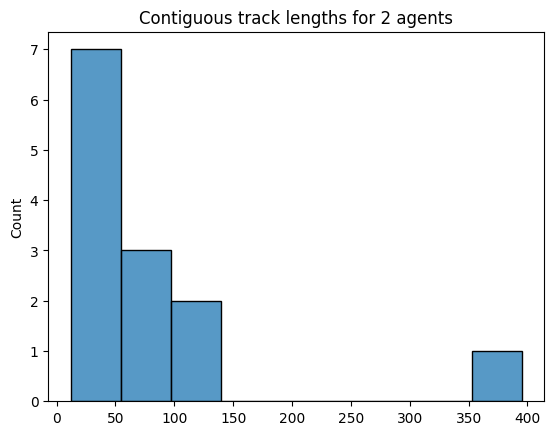

n_agents: 3, #chunks: 11, unique chunk_lengths: tensor([13, 14, 15, 18, 33, 34, 35, 36, 47, 58, 81])

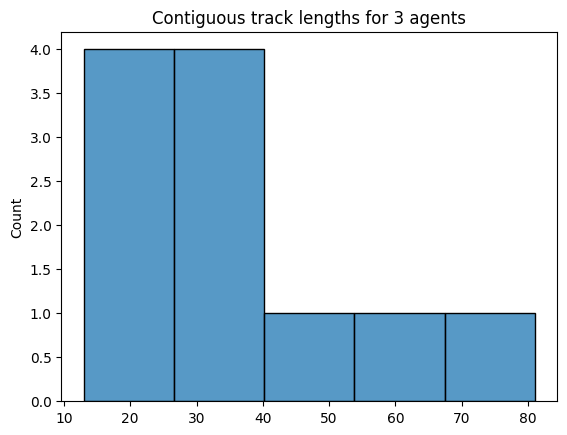

n_agents: 4, #chunks: 22, unique chunk_lengths: tensor([ 12,  15,  18,  21,  22,  23,  25,  28,  34,  40,  48,  84,
94,  98,
        159, 198, 237])

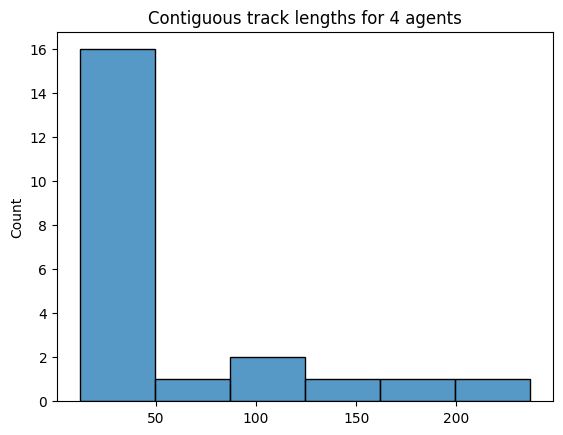

n_agents: 5, #chunks: 44, unique chunk_lengths: tensor([ 12,  13,  14,  16,  17,  18,  19,  20,  21,  22,  23,  24,
25,  26,
         28,  31,  39,  41,  42,  50,  67,  69,  75, 111])

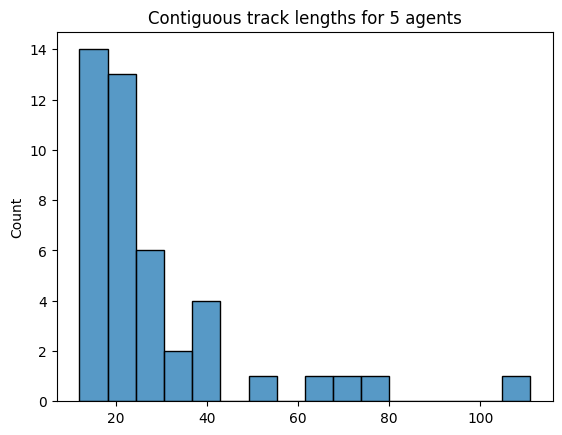

n_agents: 6, #chunks: 46, unique chunk_lengths: tensor([ 12,  13,  14,  17,  19,  21,  23,  25,  26,  27,  30,  32,
33,  34,
         35,  36,  37,  38,  40,  43,  44,  49,  50,  57, 119, 121])

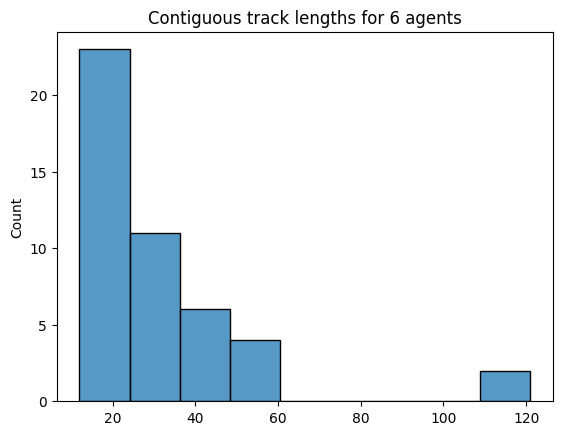

n_agents: 7, #chunks: 15, unique chunk_lengths: tensor([12, 13, 14, 15, 17, 18, 19, 21, 22, 23, 64])

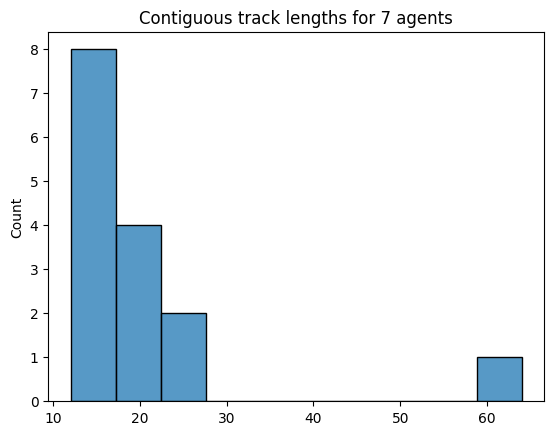

n_agents: 8, #chunks: 3, unique chunk_lengths: tensor([23, 24, 32])

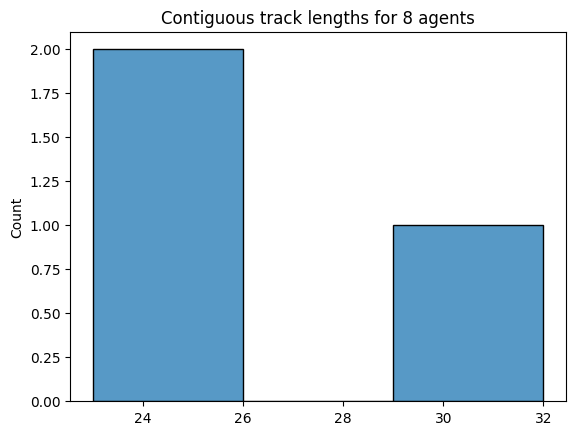

No chunks for 9 agents

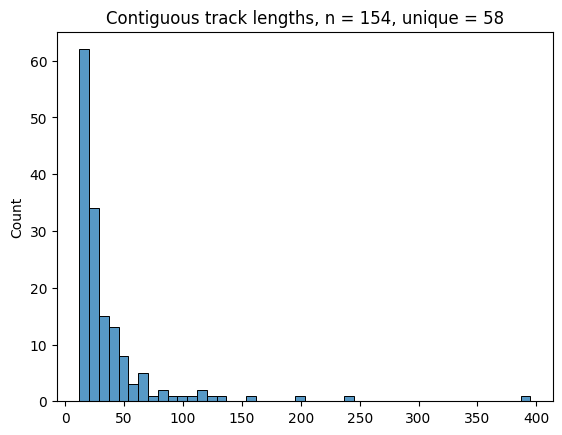

In [11]:
chunks_per_agent = {}
MIN_TRACK_LENGTH = 10
all_chunk_lengths = []
def count_unique_agents(frame_rng):
    return real_data[real_data.frame.isin(frame_rng)].track_id.nunique()

for n_agents in agents_per_frame.unique():
    if n_agents < 2:
        continue
    frame_indices = torch.where(agents_per_frame == n_agents)[0]
    chunks = []
    chunk_start = frame_indices[0]
    prev_chunk_frame = frame_indices[0]
    
    def filter_track(frame_rng):
        return (count_unique_agents(frame_rng) == n_agents) and (frame_rng[-1] - frame_rng[0] > MIN_TRACK_LENGTH)
    
    for frame in frame_indices[1:]:
        if frame == prev_chunk_frame + 1:
            prev_chunk_frame = frame
        else:
            if filter_track(range(chunk_start, prev_chunk_frame+1)):
                chunks.append(torch.tensor([chunk_start, prev_chunk_frame]))
            chunk_start = frame
            prev_chunk_frame = frame
    if filter_track(range(chunk_start, prev_chunk_frame+1)):
        chunks.append(torch.tensor([chunk_start, prev_chunk_frame]))

    if len(chunks) > 0:
        chunk_lengths = []
        for chunk in chunks:
            assert agents_per_frame[chunk[0]:chunk[1]+1].unique() == torch.tensor([n_agents]), f"{n_agents}: {chunk} "
            chunk_lengths.append(chunk[1] - chunk[0] + 1)
        chunk_lengths = torch.tensor(chunk_lengths)
        all_chunk_lengths.append(chunk_lengths)
        print(f"n_agents: {n_agents}, #chunks: {len(chunks)}, unique chunk_lengths: {chunk_lengths.unique()}")

        chunks_per_agent[n_agents] = chunks

        plt.figure()
        sns.histplot(chunk_lengths)
        plt.title(f"Contiguous track lengths for {n_agents} agents")
        plt.show()
    else:
        print(f"[red][bold]No chunks for {n_agents} agents[/bold][/red]")
all_chunk_lengths = torch.cat(all_chunk_lengths)

plt.figure()
sns.histplot(all_chunk_lengths)
plt.title(f"Contiguous track lengths, n = {len(all_chunk_lengths)}, unique = {len(all_chunk_lengths.unique())}")
plt.show()


In [12]:
all_tracks_list = []
for agent, chunks in chunks_per_agent.items():
    print(f"agent: {agent}, #chunks: {len(chunks)}")
    for chunk in tqdm(chunks):
        frame_rng = range(chunk[0], chunk[1]+1)
        mask = torch.zeros_like(all_tracks_mask)
        mask[:,frame_rng]  = 1
        mask_window = mask & all_tracks_mask
        row_indices = torch.nonzero(mask_window.sum(dim=1).squeeze())
        col_indices = torch.nonzero(mask_window.sum(dim=0)).squeeze()
        tracks_window = all_tracks[row_indices,col_indices,:]
        mask_window_final = mask_window[row_indices,col_indices]
        all_tracks_list.append((tracks_window, mask_window_final))
    
print(f"all_tracks_list: {len(all_tracks_list)}")

agent: 2, #chunks: 13

  0%|          | 0/13 [00:00<?, ?it/s]

agent: 3, #chunks: 11

  0%|          | 0/11 [00:00<?, ?it/s]

agent: 4, #chunks: 22

  0%|          | 0/22 [00:00<?, ?it/s]

agent: 5, #chunks: 44

  0%|          | 0/44 [00:00<?, ?it/s]

agent: 6, #chunks: 46

  0%|          | 0/46 [00:00<?, ?it/s]

agent: 7, #chunks: 15

  0%|          | 0/15 [00:00<?, ?it/s]

agent: 8, #chunks: 3

  0%|          | 0/3 [00:00<?, ?it/s]

all_tracks_list: 154

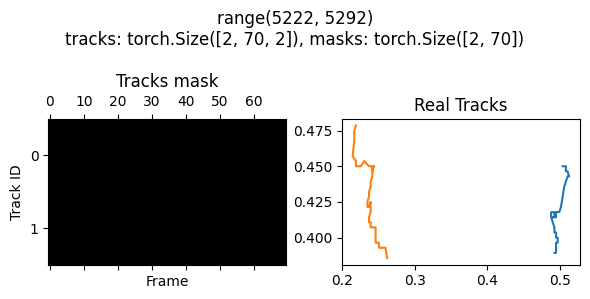

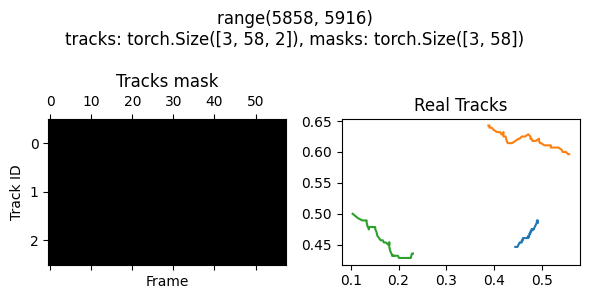

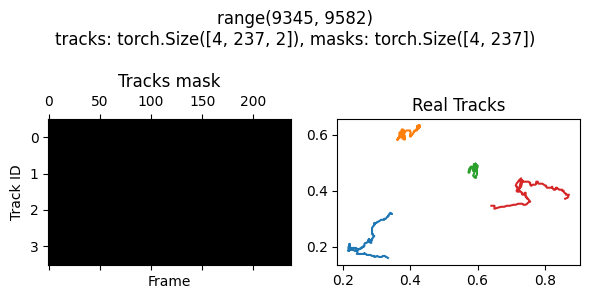

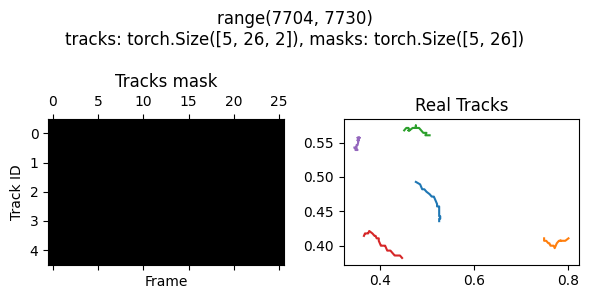

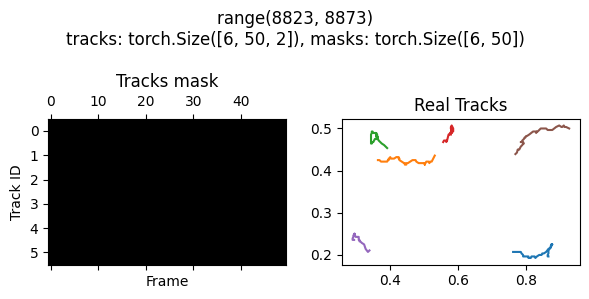

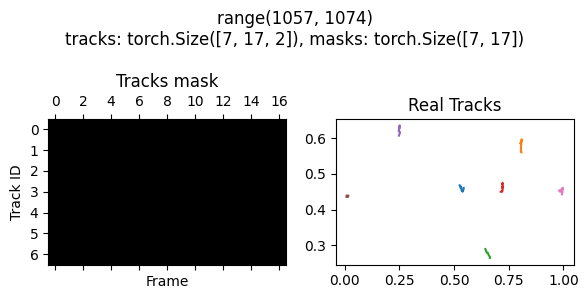

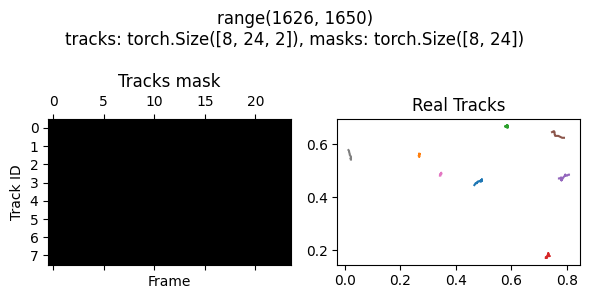

In [13]:
for agent, chunks in chunks_per_agent.items():
    # select random chunk (we have already filtered by length)
    chunk = chunks[torch.randint(0, len(chunks), (1,))]
    frame_rng = range(chunk[0], chunk[1]+1)
    mask = torch.zeros_like(all_tracks_mask)
    mask[:,frame_rng]  = 1
    mask_window = mask & all_tracks_mask
    row_indices = torch.nonzero(mask_window.sum(dim=1).squeeze())
    col_indices = torch.nonzero(mask_window.sum(dim=0)).squeeze()
    tracks_window = all_tracks[row_indices,col_indices,:]
    mask_window_final = mask_window[row_indices,col_indices]
    
    plot_tracks(tracks_window, mask_window_final, title=f"{frame_rng}\ntracks: {tracks_window.shape}, masks: {mask_window_final.shape}")


In [14]:
class RealTracksMaskedDataset(torch.utils.data.Dataset):
    def __init__(self, all_tracks_list : List[Tuple[torch.Tensor, torch.Tensor]]):
        self.all_tracks_list = all_tracks_list.copy()

    def __len__(self):
        return len(self.all_tracks_list)

    def __getitem__(self, idx):
        pair = self.all_tracks_list[idx]
        return (
            pair[0].permute(1,0,2), # tracks
            torch.zeros(pair[0].shape[0], dtype=torch.long),
            pair[1].permute(1,0) # mask
        )

all_tracks_dataset = RealTracksMaskedDataset(all_tracks_list)
print(f"all_tracks_dataset: {len(all_tracks_dataset)}")
track, species, mask = all_tracks_dataset[0]
print(f"track.shape: {track.shape}, species.shape: {species.shape}, mask.shape: {mask.shape}")


all_tracks_dataset: 154

track.shape: torch.Size([18, 2, 2]), species.shape: torch.Size([2]), mask.shape: torch.Size([18, 2])

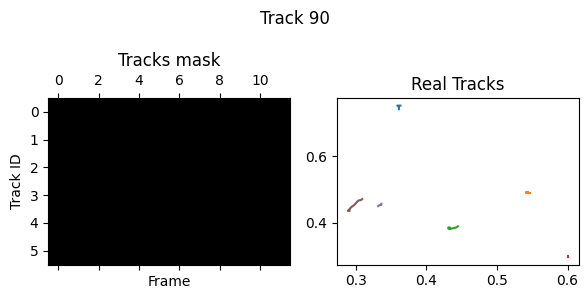

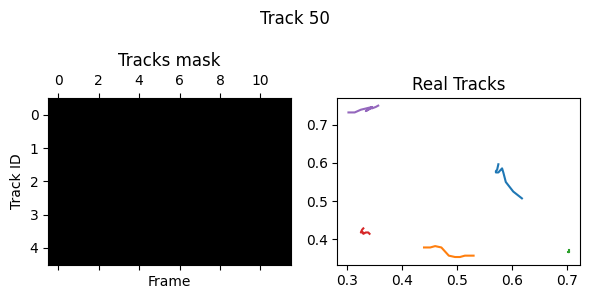

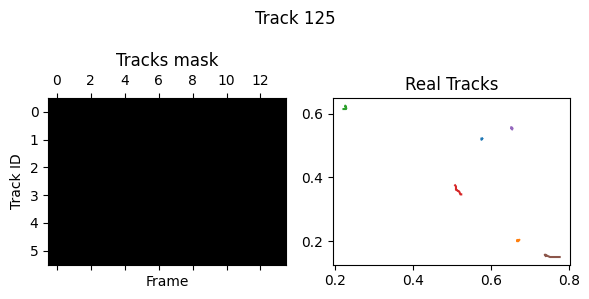

In [15]:
indices = torch.randint(0, len(all_tracks_dataset), (3,))
for i in indices:
    track, _, mask = all_tracks_dataset[i]
    plot_tracks(track.permute(1,0,2), mask.permute(1,0), title=f"Track {i}")


## The GNN

### Convert dataset to GNN format

In [16]:
class RealTracksGNNDataset(torch.utils.data.Dataset):
    def __init__(self, all_tracks_list : List[Tuple[torch.Tensor, torch.Tensor]]):
        self.all_tracks_list = all_tracks_list.copy()

    def __len__(self):
        return len(self.all_tracks_list)

    def __getitem__(self, idx):
        pair = self.all_tracks_list[idx]
        return (
            torch.as_tensor(pair[0].permute(1,0,2), dtype=torch.float32), # tracks
            torch.zeros(pair[0].shape[0], dtype=torch.long), # species
        )

all_tracks_gnn_dataset = RealTracksGNNDataset(all_tracks_list)


test_loader, train_loader = dataset2testloader(
    all_tracks_gnn_dataset,
    batch_size=1,
    return_train=True,
    device=torch.device("cpu"),
    train_size=train_size
)

logger.info(f"train_loader: {len(train_loader)}, test_loader: {len(test_loader)}")

2025-09-03 09:45:42.309 | INFO     | __main__:<module>:26 - train_loader: 61, test_loader: 93


### Create GNN, optional: load pre-trained GNN for fine-tuning

In [24]:
if do_pretrain:
    logger.info("Loading pre-trained GNN")
    from collab_env.gnn.gnn import load_model
    model_name = "enhanced_gnn_vpluspplus_a"
    model_rel_path = "trained_models/enhanced/boid_single_species_basic_enhanced_gnn_vpluspplus_a_n0.005_h1_vr0.5_s0"
    # model_rel_path = "trained_models/boid_single_species_basic/trained_models/boid_single_species_basic_vpluspplus_a_n0.005_h1_vr0.5_s2"
    model, mdl_spec, mdl_train_spec = load_model(model_name, model_rel_path, ".")
else:
    logger.info("Training GNN from scratch")
    from collab_env.gnn.gnn_definition import GNN

    in_node_dim = 19 # no food
    heads = 1

    model_spec = {
        "model_name": "vpluspplus_a",
        "node_feature_function": "vel_plus_pos_plus",
        "node_prediction": "acc",
        "prediction_integration": "Euler",
        "input_differentiation": "finite",
        "in_node_dim": in_node_dim,
        "start_frame": 3,
        "heads": heads
    }

    model = GNN(**model_spec)    

2025-09-03 09:55:29.923 | INFO     | __main__:<module>:2 - Loading pre-trained GNN
2025-09-03 09:55:29.924 | DEBUG    | collab_env.gnn.gnn:load_model:974 - Loaded model spec.
2025-09-03 09:55:29.924 | DEBUG    | collab_env.gnn.gnn:load_model:979 - Loaded training spec.
2025-09-03 09:55:29.926 | DEBUG    | collab_env.gnn.gnn:load_model:996 - Loaded enhanced model.
2025-09-03 09:55:29.928 | DEBUG    | collab_env.gnn.gnn:load_model:1004 - Loaded model.


### Train GNN

2025-09-03 10:08:16.648 | DEBUG    | collab_env.gnn.gnn:train_rules_gnn:640 - Starting epoch 1/50
2025-09-03 10:08:16.649 | DEBUG    | collab_env.gnn.gnn:train_rules_gnn:649 - Epoch 1/50 | Processing batch 1/61


2025-09-03 10:08:20.487 | DEBUG    | collab_env.gnn.gnn:train_rules_gnn:649 - Epoch 1/50 | Processing batch 61/61
2025-09-03 10:08:20.516 | DEBUG    | collab_env.gnn.gnn:train_rules_gnn:675 - Epoch 000 | Train loss: 0.0002414
2025-09-03 10:08:20.517 | DEBUG    | collab_env.gnn.gnn:train_rules_gnn:680 - Validating...
2025-09-03 10:08:23.427 | DEBUG    | collab_env.gnn.gnn:train_rules_gnn:715 - Epoch 000 | Train: 0.0002414 | Val: 0.000277 | Patience: 0/3
2025-09-03 10:08:23.428 | DEBUG    | collab_env.gnn.gnn:train_rules_gnn:640 - Starting epoch 2/50
2025-09-03 10:08:23.428 | DEBUG    | collab_env.gnn.gnn:train_rules_gnn:649 - Epoch 2/50 | Processing batch 1/61
2025-09-03 10:08:27.092 | DEBUG    | collab_env.gnn.gnn:train_rules_gnn:649 - Epoch 2/50 | Processing batch 61/61
2025-09-03 10:08:27.206 | DEBUG    | collab_env.gnn.gnn:train_rules_gnn:675 - Epoch 001 | Train loss: 0.0002418
2025-09-03 10:08:27.207 | DEBUG    | collab_env.gnn.gnn:train_rules_gnn:680 - Validating...
2025-09-03 10:

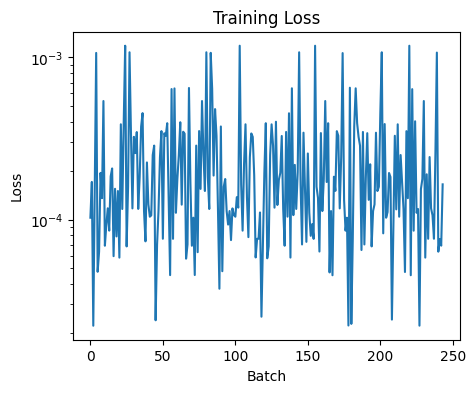

In [27]:
if do_train:

    seed  = 0

    torch.manual_seed(seed)
    np.random.seed(seed)

    train_losses, trained_model, _ = train_rules_gnn(
        model,
        train_loader,
        species_dim = 1,
        epochs = 50,
        training = True,
        sigma = 0.0,
        device = device,
        lr = 1e-5,
        val_dataloader = test_loader,
        early_stopping_patience = 3,
        min_delta = 1e-5
    )

    #  save model
    model_output = expand_path(
        f"trained_models/{Path(real_data_fn).stem}.pt",
        get_project_root(),
    )
    torch.save(model.state_dict(), model_output)
    logger.info(f"Model saved to {model_output}.")

    plt.figure(figsize=(5, 4))
    plt.semilogy(train_losses.ravel())
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.show()

### Generate rollouts

In [28]:
rollout = 5
rollout_frames = 100
_, _, rollout_result = train_rules_gnn(
    model,
    test_loader,
    species_dim = 1,
    epochs = 1,
    lr = None,
    training = False,
    device = device,
    rollout = 5,
    rollout_frames = 100,
    collect_debug=True,  
    val_dataloader=None
)

rollout_path =expand_path(
    f"trained_models/{Path(real_data_fn).stem}_rollout_{rollout}_frames_{rollout_frames}.pt",
    get_project_root(),
)
with open(rollout_path, "wb") as f: # 'wb' for write binary
    pickle.dump(rollout_result, f)
logger.info(f"Rollout saved to {rollout_path}.")


2025-09-03 10:08:48.575 | DEBUG    | collab_env.gnn.gnn:train_rules_gnn:634 - rolling out...
2025-09-03 10:08:48.575 | DEBUG    | collab_env.gnn.gnn:train_rules_gnn:640 - Starting epoch 1/1
2025-09-03 10:08:48.576 | DEBUG    | collab_env.gnn.gnn:train_rules_gnn:649 - Epoch 1/1 | Processing batch 1/93
2025-09-03 10:08:51.137 | DEBUG    | collab_env.gnn.gnn:train_rules_gnn:649 - Epoch 1/1 | Processing batch 93/93
2025-09-03 10:08:51.180 | DEBUG    | collab_env.gnn.gnn:train_rules_gnn:675 - Epoch 000 | Train loss: 0.000239
2025-09-03 10:08:51.419 | INFO     | __main__:<module>:23 - Rollout saved to /Users/dima/git/collab-environment/trained_models/rgb_1_tracks_rollout_5_frames_100.pt.


### Visualize rollouts

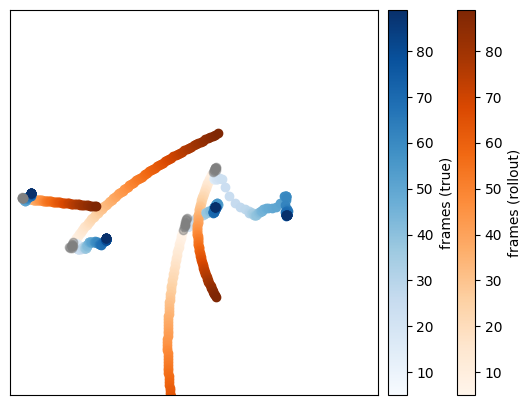

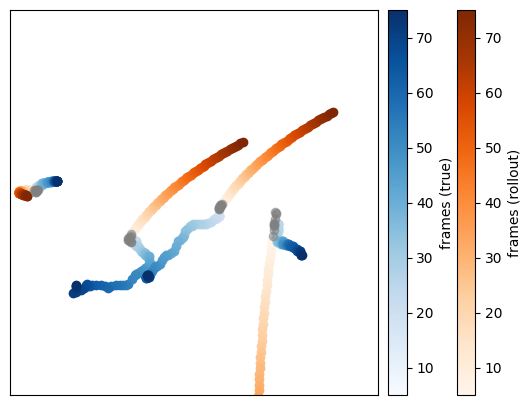

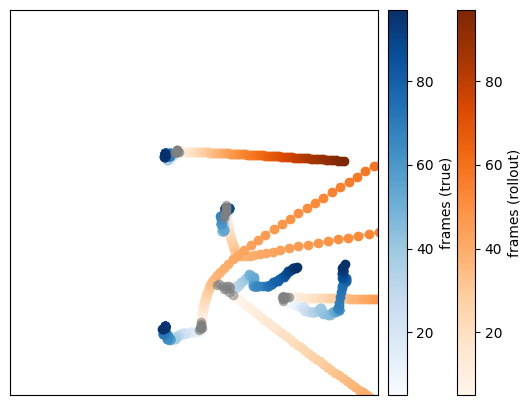

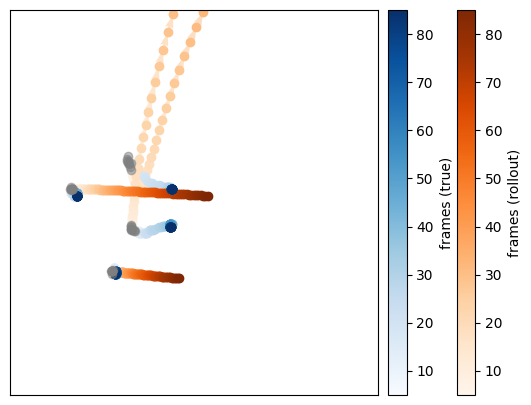

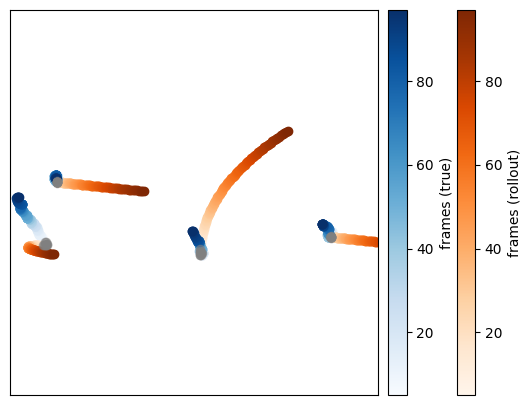

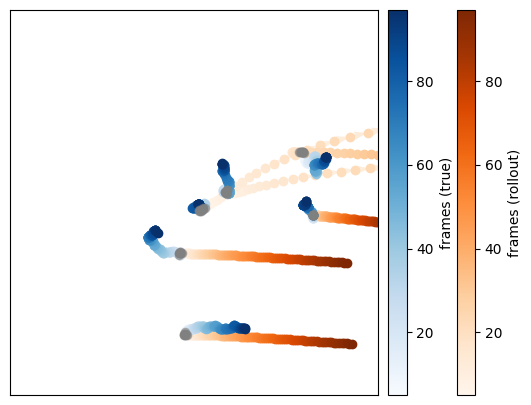

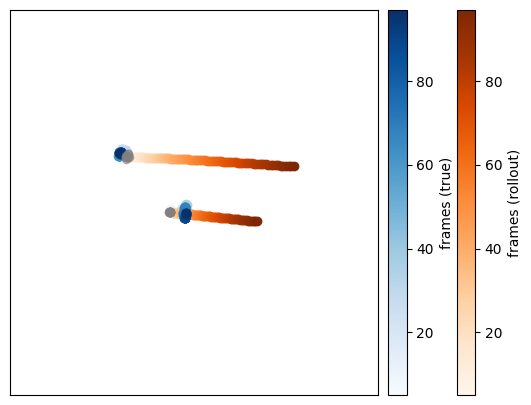

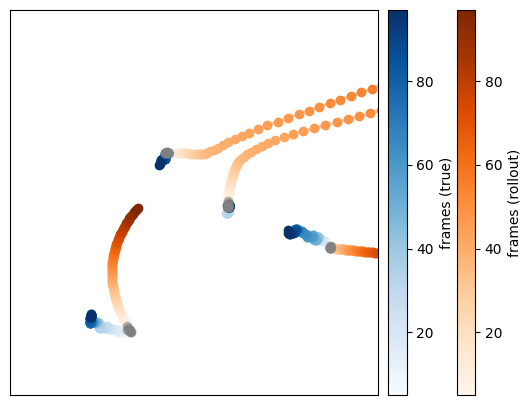

In [29]:
MIN_EPISODE_LENGTH = 80

for file_id in range(len(rollout_result[0])):
    actual_pos, actual_vel, actual_acc, gnn_pos, gnn_vel, gnn_acc, frame_sets = debug_result2prediction(
                    rollout_result,
                    file_id = file_id, epoch_num = 0)
    actual_track_len = actual_pos.shape[1]
    if actual_track_len < MIN_EPISODE_LENGTH:
        continue
    starting_frame = 0
    rollout_starting_frame = 5
    ending_frame = actual_track_len - rollout_starting_frame
    # fig, ax = plt.subplots(figsize=(6,5))
    _ = static_visualize_2sets(actual_pos[0], actual_vel[0], gnn_pos[0], gnn_vel[0],
                    starting_frame = starting_frame, rollout_starting_frame = rollout_starting_frame, 
                                ending_frame = ending_frame, ax = None)
    # plt.suptitle(f"Rollout {file_id}")
    # plt.show()
